In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn

In [2]:
phone_df = pd.read_csv('data/Phone Complaints.csv')
phone_df.head()

,Issue Occurred,Form,Method,Issue,City,State,Zip
0,2014-10-31 12:29:24,Phone,Wireless (cell phone/other mobile device),Cramming (unauthorized charges on your phone b...,Minnetonka,MN,55345
1,2014-10-31 07:03:00,Phone,Internet (VOIP),Telemarketing (including do not call and spoof...,Berwick,PA,18603
2,2014-10-31 00:36:00,Phone,Wireless (cell phone/other mobile device),Telemarketing (including do not call and spoof...,Johnstown,PA,15902
3,2014-10-31 13:34:38,Phone,Wireless (cell phone/other mobile device),Availability (including rural call completion),Oconomowoc,WI,53066
4,2014-10-31 14:05:16,Phone,Internet (VOIP),Availability (including rural call completion),Somers,CT,06071


In [3]:
phone_df_new = phone_df[(phone_df['Issue Occurred'] >= '2015') & (phone_df['Issue Occurred'] < '2020')]
phone_df_new = phone_df_new[(phone_df_new != 'Unknown').all(axis=1)]
phone_df_new.head()

,Issue Occurred,Form,Method,Issue,City,State,Zip
5950,2015-09-01 13:00:00,Phone,Wireless (cell phone/other mobile device),Telemarketing (including do not call and spoof...,Fallbrook,CA,92028
11148,2015-12-12 10:20:00,Phone,Wireless (cell phone/other mobile device),Robocalls,Oakland,CA,94619
12523,2015-12-16 11:15:00,Phone,Wireless (cell phone/other mobile device),Robocalls,Portland,OR,97213
14243,2015-12-14 15:14:00,Phone,Wired,Telemarketing (including do not call and spoof...,Test,AL,11111
18099,2015-01-01 00:00:20,Phone,Wired,Interference (including signal jammers),Yonkers,NY,10710


## Forcasting with LinearRegression

In [4]:
method_df = phone_df_new[['Issue Occurred', 'Method']]
method_df['Issue Year'] = pd.to_datetime(method_df['Issue Occurred'], format='%Y-%m-%d %H:%M:%S').dt.year.astype('int64')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
method_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1175267 entries, 5950 to 1274702
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   Issue Occurred  1175267 non-null  object
 1   Method          1175267 non-null  object
 2   Issue Year      1175267 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 35.9+ MB


In [6]:
method_df_new = method_df[['Issue Year', 'Method']]
method_df_new = method_df_new.groupby(['Issue Year', 'Method']).size().reset_index().rename(columns={0:'count'})
method_df_new = method_df_new.pivot(index='Issue Year', columns='Method', values='count')
method_df_new

Method,Internet (VOIP),Wired,Wireless (cell phone/other mobile device)
Issue Year,,,
2015,19244,82157,121147
2016,16133,67460,125870
2017,16081,64093,156345
2018,19102,67025,190940
2019,40759,72159,116752


Text(0.5, 1.0, 'Method count per year from 2015 to 2019')

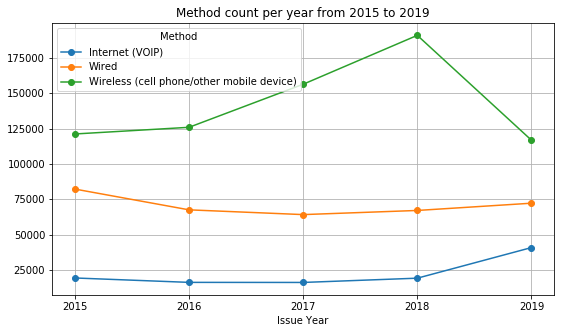

In [7]:
from sklearn.linear_model import LinearRegression

method_df_new.plot(y=method_df_new.columns, grid=True, xticks=method_df_new.index, marker='o', figsize=(9,5))
plt.title('Method count per year from 2015 to 2019')

In [8]:
# make linear fit for each method
lin_models = {}
x = np.array(method_df_new.index).reshape(-1,1)

for col in method_df_new.columns:
    y = method_df_new[col]
    lin_model = LinearRegression()
    lin_model.fit(x,y)
    lin_models[col] = lin_model

for m in lin_models:
    print(lin_models[m].coef_)

[4599.9]
[-2043.1]
[5628.]


In [9]:
# line plots
x_ticks = np.arange(2015, 2025)

ys = []
for m in lin_models:
    y = lin_models[m].coef_[0] * x_ticks + lin_models[m].intercept_
    ys.append(y)


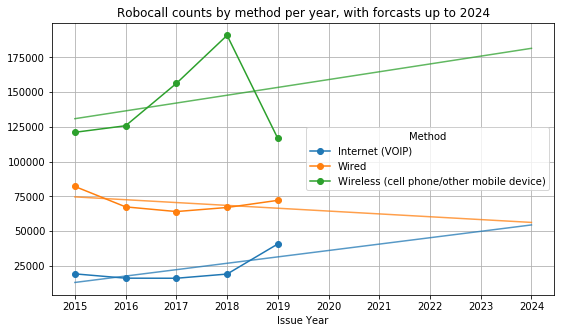

In [10]:
method_df_new.plot(y=method_df_new.columns, grid=True, xticks=x_ticks, marker='o', figsize=(9,5))

# reset color cycle
plt.gca().set_prop_cycle(None)

# plot the regression lines
for y in ys:
    plt.plot(x_ticks, y, alpha=0.75)
plt.title('Robocall counts by method per year, with forcasts up to 2024')
plt.show()

Perhaps yearly forcasting is not very accurate after all. We will try doing by month instead. This time, using a library called Prophet created by Facebook.

In [11]:
# Importing was... troublesome.
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [12]:
method_df_new2 = method_df[['Issue Occurred', 'Method']]
method_df_new2['Issue Occurred'] = pd.to_datetime(method_df_new2['Issue Occurred'], format='%Y-%m-%d %H:%M:%S').dt.date
method_df_new2.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Issue Occurred,Method
5950,2015-09-01,Wireless (cell phone/other mobile device)
11148,2015-12-12,Wireless (cell phone/other mobile device)
12523,2015-12-16,Wireless (cell phone/other mobile device)
14243,2015-12-14,Wired
18099,2015-01-01,Wired


In [13]:
method_df_new2 = method_df_new2.groupby(['Issue Occurred', 'Method']).size().reset_index().rename(columns={0:'count'})
method_df_new2 = method_df_new2.pivot(index='Issue Occurred', columns='Method', values='count')
method_df_new2.head()

Method,Internet (VOIP),Wired,Wireless (cell phone/other mobile device)
Issue Occurred,,,
2015-01-01,39.0,175.0,205.0
2015-01-02,53.0,180.0,282.0
2015-01-03,45.0,116.0,161.0
2015-01-04,11.0,33.0,109.0
2015-01-05,87.0,268.0,408.0


In [14]:
method_df_new2 = method_df_new2.reset_index()
method_df_new2.head()

Method,Issue Occurred,Internet (VOIP),Wired,Wireless (cell phone/other mobile device)
0,2015-01-01,39.0,175.0,205.0
1,2015-01-02,53.0,180.0,282.0
2,2015-01-03,45.0,116.0,161.0
3,2015-01-04,11.0,33.0,109.0
4,2015-01-05,87.0,268.0,408.0


In [15]:
method_df_new2['Issue Occurred'] = pd.to_datetime(method_df_new2['Issue Occurred'], format='%Y-%m-%d %H:%M:%S')
method_df_new2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 4 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Issue Occurred                             1826 non-null   datetime64[ns]
 1   Internet (VOIP)                            1825 non-null   float64       
 2   Wired                                      1826 non-null   float64       
 3   Wireless (cell phone/other mobile device)  1826 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 57.2 KB


In [16]:
month_df = method_df_new2.groupby(method_df_new2['Issue Occurred'].dt.to_period('M')).agg('sum').astype(int)
month_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 60 entries, 2015-01 to 2019-12
Freq: M
Data columns (total 3 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Internet (VOIP)                            60 non-null     int64
 1   Wired                                      60 non-null     int64
 2   Wireless (cell phone/other mobile device)  60 non-null     int64
dtypes: int64(3)
memory usage: 1.9 KB


In [17]:
month_df.index = month_df.index.to_timestamp()
month_df.head()

Method,Internet (VOIP),Wired,Wireless (cell phone/other mobile device)
Issue Occurred,,,
2015-01-01,1624,6283,9413
2015-02-01,1353,5519,8587
2015-03-01,1767,7186,10653
2015-04-01,1602,6996,11075
2015-05-01,1468,6459,8925


In [18]:
# make linear fit for each method
lin_models = {}
x = np.array(month_df.index).reshape(-1,1).astype('float')
y_cols = month_df.columns

for col in y_cols:
    y = month_df[col]
    lin_model = LinearRegression()
    lin_model.fit(x,y)
    lin_models[col] = lin_model

for m in lin_models:
    print(lin_models[m].coef_, lin_models[m].intercept_)

[1.19516092e-14] -16043.344409768582
[-5.74710277e-15] 14488.394678591852
[1.39628617e-14] -9059.801208234041


In [19]:
# get the pred ys
x_ticks = np.array([np.datetime64('{}-01-01'.format(y), 'ns') for y in np.arange(2015, 2025)]).astype('float')
print(x_ticks)
y_preds = []

for m in lin_models:
    y_preds.append(lin_models[m].predict(x_ticks.reshape(-1,1)))

print(y_preds)

[1.4200704e+18 1.4516064e+18 1.4832288e+18 1.5147648e+18 1.5463008e+18
 1.5778368e+18 1.6094592e+18 1.6409952e+18 1.6725312e+18 1.7040672e+18]
[array([ 928.78202835, 1305.68797566, 1683.62654199, 2060.5324893 ,
       2437.43843661, 2814.34438391, 3192.28295025, 3569.18889756,
       3946.09484486, 4323.00079217]), array([6327.10414263, 6145.86350953, 5964.12632675, 5782.88569365,
       5601.64506055, 5420.40442745, 5238.66724467, 5057.42661157,
       4876.18597847, 4694.94534537]), array([10768.44534609, 11208.77815166, 11650.31734848, 12090.65015405,
       12530.98295961, 12971.31576518, 13412.854962  , 13853.18776757,
       14293.52057314, 14733.85337871])]


In [20]:
x_ticks.astype('datetime64[ns]')

array(['2015-01-01T00:00:00.000000000', '2016-01-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000', '2020-01-01T00:00:00.000000000',
       '2021-01-01T00:00:00.000000000', '2022-01-01T00:00:00.000000000',
       '2023-01-01T00:00:00.000000000', '2024-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

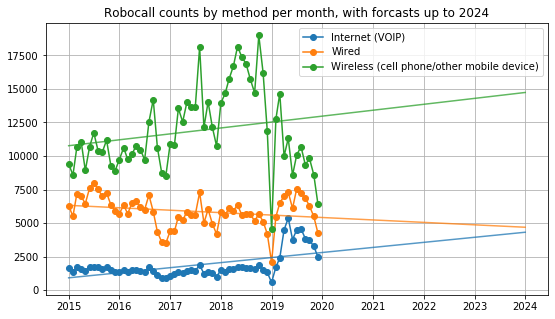

In [21]:
# make plots
x_ticks_dt = x_ticks.astype('datetime64[ns]')
plt.figure(figsize=(9,5))
plt.grid(True)

for col in month_df.columns:
    plt.plot(month_df.index, month_df[col], marker='o')
#month_df.plot(y=month_df.columns, grid=True, marker='o', xticks=x_ticks_dt, figsize=(9,5))
plt.legend(month_df.columns)

plt.gca().set_prop_cycle(None)

#x_ticks_dt = x_ticks.astype('datetime64[ns]')
plt.plot(x_ticks_dt, np.array(y_preds).T, alpha=0.75)
plt.title('Robocall counts by method per month, with forcasts up to 2024')
plt.show()

Looks like the lines are not much different from that from the month. Let's use FBProphet to forecast.

In [22]:
month_df = month_df.reset_index()
month_df.info()
#pd.to_datetime(month_df['Issue Occurred'].to_timestamp(), format='%Y-%m')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Issue Occurred                             60 non-null     datetime64[ns]
 1   Internet (VOIP)                            60 non-null     int64         
 2   Wired                                      60 non-null     int64         
 3   Wireless (cell phone/other mobile device)  60 non-null     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 2.0 KB


In [23]:
help(Prophet.plot)

Help on function plot in module fbprophet.forecaster:

plot(self, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='ds', ylabel='y')
    Plot the Prophet forecast.
    
    Parameters
    ----------
    fcst: pd.DataFrame output of self.predict.
    ax: Optional matplotlib axes on which to plot.
    uncertainty: Optional boolean to plot uncertainty intervals.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    xlabel: Optional label name on X-axis
    ylabel: Optional label name on Y-axis
    
    Returns
    -------
    A matplotlib figure.



INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=T

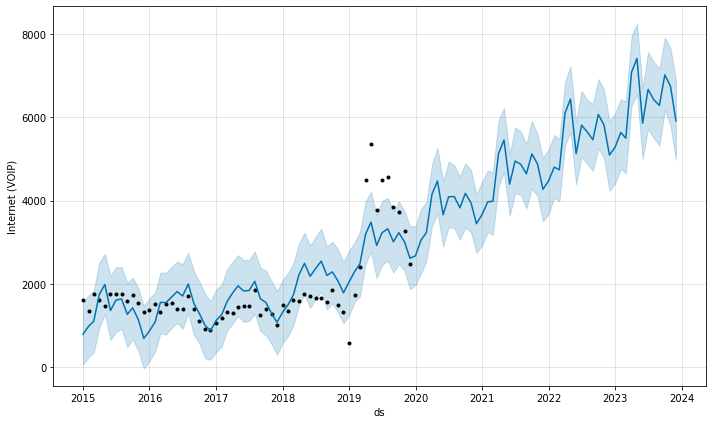

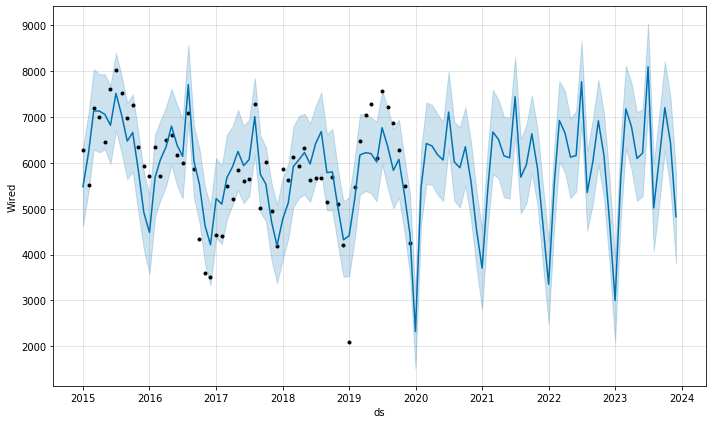

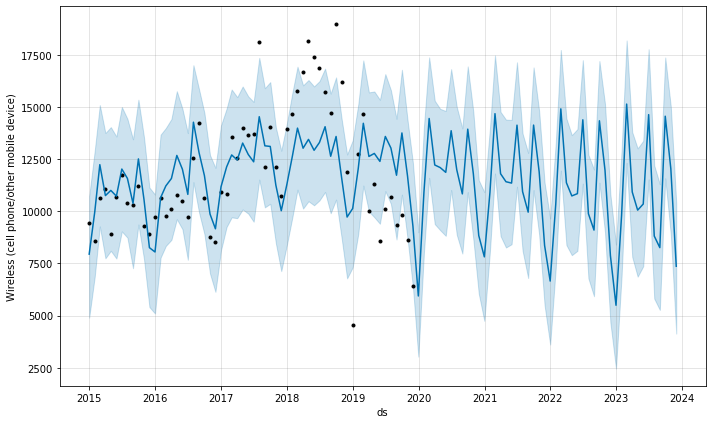

In [36]:
# do for loop for each method
#plt.figure(figsize=(9,5))
#ax = plt.subplot()
#ax.set_color_cycle(['blue', 'orange', 'green'])

#colors = ['blue', 'orange', 'green']

for c in ['Internet (VOIP)', 'Wired', 'Wireless (cell phone/other mobile device)']:
    df = month_df[['Issue Occurred', c]]
    df.columns = ['ds', 'y']
    
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=48, freq='M')
    forecast = m.predict(future)
    m.plot(forecast, ylabel=c)

Plot are ordered from top to bottom: "Internet (VOIP)", "Wired", "Wireless (cell phone/other mobile device)"

__Note:__ Please note that the plots are assuming that the COVID-19 pandemic never happened. The number of robocalls are reportedly much lower as the pandemic in America took place.

The monthly plots give out a better forecast, but what about per week?

In [25]:
week_df = method_df_new2.resample('W', on='Issue Occurred').sum().reset_index()
week_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 4 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Issue Occurred                             262 non-null    datetime64[ns]
 1   Internet (VOIP)                            262 non-null    float64       
 2   Wired                                      262 non-null    float64       
 3   Wireless (cell phone/other mobile device)  262 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 8.3 KB


In [26]:
# do Linear Regression for the weekly plot
week_df2 = week_df
week_df2 = week_df2.set_index('Issue Occurred')
week_df2.head()

Method,Internet (VOIP),Wired,Wireless (cell phone/other mobile device)
Issue Occurred,,,
2015-01-04,148.0,504.0,757.0
2015-01-11,364.0,1549.0,2284.0
2015-01-18,382.0,1536.0,2202.0
2015-01-25,381.0,1409.0,2191.0
2015-02-01,362.0,1347.0,2060.0


In [27]:
# make linear fit for each method (weekly)
lin_models = {}
x = np.array(week_df2.index).reshape(-1,1).astype('float')
y_cols = week_df2.columns

for col in y_cols:
    y = week_df2[col]
    lin_model = LinearRegression()
    lin_model.fit(x,y)
    lin_models[col] = lin_model

for m in lin_models:
    print(lin_models[m].coef_, lin_models[m].intercept_)

[2.69331033e-15] -3613.0799892688337
[-1.35381495e-15] 3376.6388466579983
[3.06817914e-15] -1886.0394254050766


In [38]:
weeks_1525 = np.arange('2015-01-04', '2025-01-01', 7, dtype='datetime64[D]')
x_ticks = np.array([np.datetime64(date, 'ns') for date in weeks_1525]).astype('float')
y_preds = []

for m in lin_models:
    y_preds.append(lin_models[m].predict(x_ticks.reshape(-1,1)))

print(y_preds)

[array([ 212.30839114,  213.93730523,  215.56621931,  217.1951334 ,
        218.82404749,  220.45296157,  222.08187566,  223.71078974,
        225.33970383,  226.96861792,  228.597532  ,  230.22644609,
        231.85536018,  233.48427426,  235.11318835,  236.74210243,
        238.37101652,  239.99993061,  241.62884469,  243.25775878,
        244.88667287,  246.51558695,  248.14450104,  249.77341512,
        251.40232921,  253.0312433 ,  254.66015738,  256.28907147,
        257.91798555,  259.54689964,  261.17581373,  262.80472781,
        264.4336419 ,  266.06255599,  267.69147007,  269.32038416,
        270.94929824,  272.57821233,  274.20712642,  275.8360405 ,
        277.46495459,  279.09386868,  280.72278276,  282.35169685,
        283.98061093,  285.60952502,  287.23843911,  288.86735319,
        290.49626728,  292.12518136,  293.75409545,  295.38300954,
        297.01192362,  298.64083771,  300.2697518 ,  301.89866588,
        303.52757997,  305.15649405,  306.78540814,  308.4143

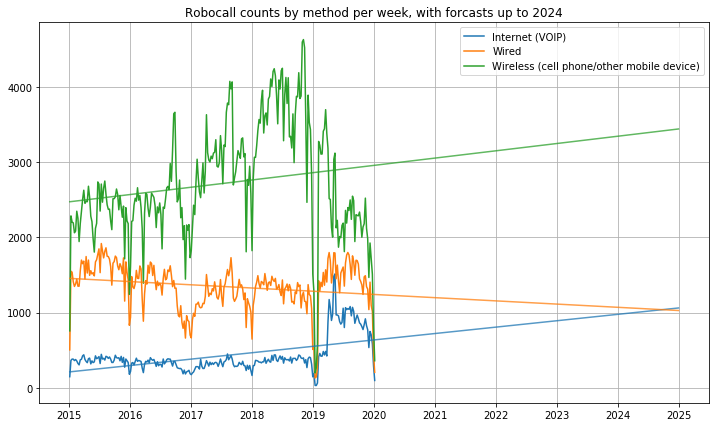

In [41]:
# make plots
x_ticks_dt = x_ticks.astype('datetime64[ns]')
plt.figure(figsize=(12,7))
plt.grid(True)

for col in week_df2.columns:
    plt.plot(week_df2.index, week_df2[col])
plt.legend(week_df2.columns)

plt.gca().set_prop_cycle(None)

#x_ticks_dt = x_ticks.astype('datetime64[ns]')
plt.plot(x_ticks_dt, np.array(y_preds).T, alpha=0.75)
plt.title('Robocall counts by method per week, with forcasts up to 2024')
plt.show()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=T

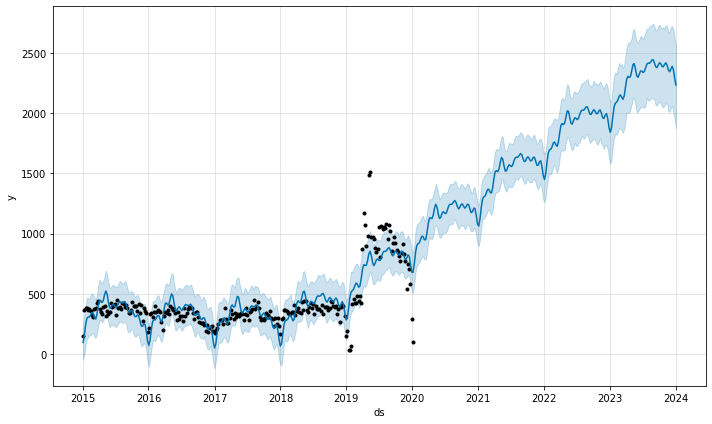

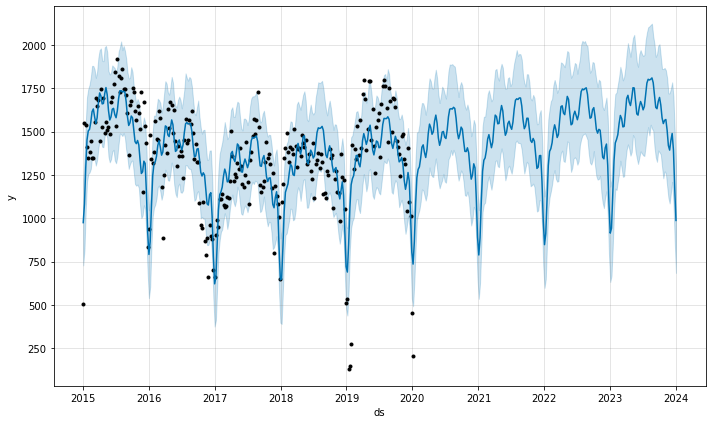

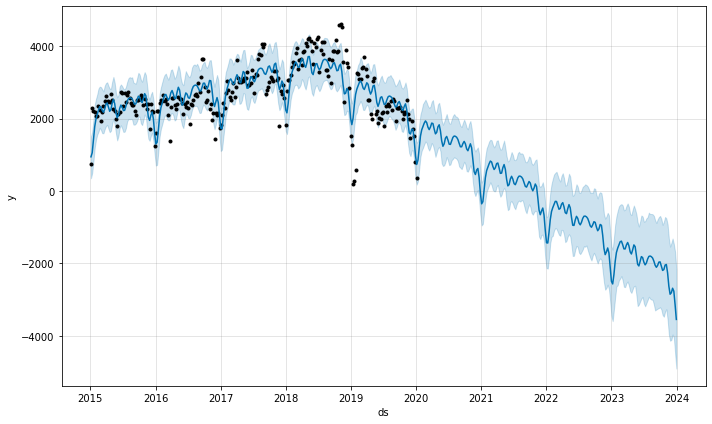

In [44]:
for c in ['Internet (VOIP)', 'Wired', 'Wireless (cell phone/other mobile device)']:
    df = week_df[['Issue Occurred', c]]
    df.columns = ['ds', 'y']
    
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods=52*4, freq='W')
    forecast = m.predict(future)
    m.plot(forecast)

Plot are ordered from top to bottom: "Internet (VOIP)", "Wired", "Wireless (cell phone/other mobile device)"

Interestingly, the plot for Wireless shows that the number of Wireless robocalls per week is declining, but of course, given the rise until 2018, the number will increase again sometime in the future.